<a href="https://colab.research.google.com/github/mateusz-kacpura/exercises-python/blob/main/Algorytmy_KMeans_i_BFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

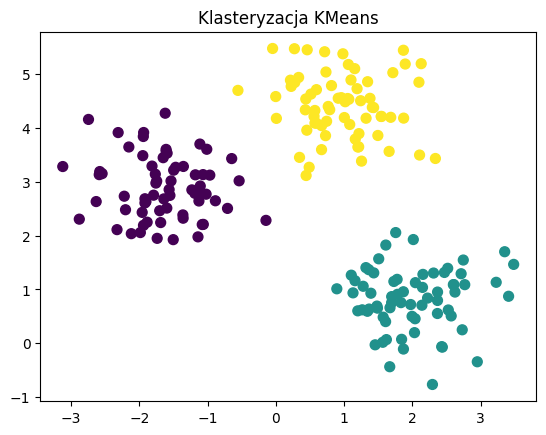

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

class KMeans():
    def __init__(self, n_clusters=2, max_iterations=100):
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations

    def fit(self, X):
        self.X = X
        # Inicjalizacja centroidów losowo wybranymi punktami z danych
        self.centroids = X[np.random.choice(len(X), self.n_clusters, replace=False)]
        for _ in range(self.max_iterations):
            self.labels = self.assign_clusters()
            new_centroids = self.calculate_centroids()
            # Sprawdzenie, czy centroidy się zmieniły
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

    def assign_clusters(self):
        labels = []
        for x in self.X:
            # Obliczanie odległości Euklidesowych do centroidów
            distances = np.linalg.norm(x - self.centroids, axis=1)
            # Przypisanie punktu do najbliższego centroidu
            labels.append(np.argmin(distances))
        return np.array(labels)

    def calculate_centroids(self):
        centroids = []
        for i in range(self.n_clusters):
            # Wybieranie punktów należących do klastra
            points = self.X[self.labels == i]
            if len(points) == 0:
                # Jeśli klaster jest pusty, wybranie losowego punktu jako centroidu
                centroids.append(self.X[np.random.choice(len(self.X))])
            else:
                # Obliczanie nowego centroidu jako średniej punktów w klastrze
                centroids.append(points.mean(axis=0))
        return np.array(centroids)

# Generowanie danych
X, y_true = make_blobs(n_samples=200, centers=3, cluster_std=0.60, random_state=0)

# Tworzenie i trenowanie modelu KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
labels = kmeans.labels

# Wizualizacja wyników
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.title('Klasteryzacja KMeans')
plt.show()

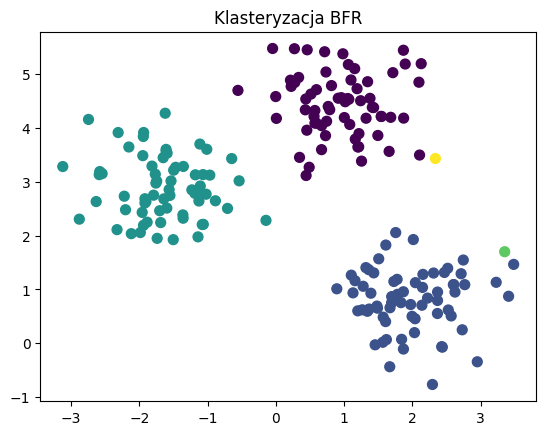

In [12]:
class BFR:
    def __init__(self, n_clusters=2, threshold=2.0):
        self.n_clusters = n_clusters
        self.threshold = threshold
        self.clusters = {}

    def fit(self, X):
        self.X = X
        initial_batch = self.X[:len(self.X)//2]

        # Inicjalizacja klastrów za pomocą KMeans
        kmeans = KMeans(n_clusters=self.n_clusters)
        kmeans.fit(initial_batch)

        for i in range(self.n_clusters):
            points = initial_batch[kmeans.labels == i]
            stats = self.calculate_statistics(points)
            self.clusters[i] = stats

        # Przetwarzanie pozostałych danych
        remainder_data = self.X[len(self.X)//2:]
        for x in remainder_data:
            assigned = False
            for cluster_id, stats in self.clusters.items():
                dist = self.mahalanobis_distance(x, stats)
                if dist < self.threshold:
                    self.update_statistics(x, stats)
                    assigned = True
                    break
            if not assigned:
                # Utworzenie nowego klastra dla punktu
                new_cluster_id = max(self.clusters.keys()) + 1
                stats = self.calculate_statistics(np.array([x]))
                self.clusters[new_cluster_id] = stats

    def calculate_statistics(self, points):
        N = len(points)
        SUM = np.sum(points, axis=0)
        SUMSQ = np.sum(points**2, axis=0)
        return {'N': N, 'SUM': SUM, 'SUMSQ': SUMSQ}

    def update_statistics(self, x, stats):
        stats['N'] += 1
        stats['SUM'] += x
        stats['SUMSQ'] += x**2

    def mahalanobis_distance(self, x, stats):
        N = stats['N']
        SUM = stats['SUM']
        SUMSQ = stats['SUMSQ']

        mu = SUM / N
        variance = (SUMSQ / N) - (mu**2)
        variance[variance == 0] = 1e-10  # Unikanie dzielenia przez zero
        diff = x - mu
        mdist = np.sqrt(np.sum((diff**2) / variance))
        return mdist

    def predict(self, X):
        labels = []
        for x in X:
            distances = []
            for cluster_id, stats in self.clusters.items():
                dist = self.mahalanobis_distance(x, stats)
                distances.append((dist, cluster_id))
            # Przypisanie do najbliższego klastra
            distances.sort()
            labels.append(distances[0][1])
        return np.array(labels)

# Tworzenie i trenowanie modelu BFR
bfr = BFR(n_clusters=3, threshold=3.0)
bfr.fit(X)
labels_bfr = bfr.predict(X)

# Wizualizacja wyników BFR
plt.scatter(X[:, 0], X[:, 1], c=labels_bfr, s=50, cmap='viridis')
plt.title('Klasteryzacja BFR')
plt.show()